In [1]:
import numpy
import torch
import torch.nn as nn
import numpy as np
import random
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn import decomposition
import copy
import time
import random
import CTRNN

torch.manual_seed(66)
np.random.seed(66)
random.seed(66)


In [2]:
# create a trial

# trial params
stim_start = 1
stim_duration = 0.5 # seconds
delay_duration = 1.5 # seconds
choice_start = stim_start + stim_duration + delay_duration
choice_duration = 1 # seconds
post_duration = 1 # seconds

duration = stim_start + stim_duration + delay_duration + choice_duration + post_duration
dt = 0.5 # seconds

step_lims = torch.arange(0, duration + dt, dt)
n_steps = int(duration / dt)

class Trial():
    def __init__(self, stimulus):
        self.target_val = stimulus
        self.stimulus = torch.zeros((n_steps,2))
        self.stimulus[torch.where(torch.logical_and(step_lims>=stim_start, step_lims<stim_start+stim_duration)),stimulus] = 1
        self.target = torch.zeros((n_steps,2))
        self.target[np.where(np.logical_and(step_lims>=choice_start, step_lims<choice_start+choice_duration)),self.target_val] = 1

t0 = Trial(stimulus=0)

/var/folders/0w/w054ky8d6cz1ztxm_kk48ktm0000gn/T/ipykernel_90325/2908586182.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646981653/work/torch/csrc/utils/tensor_new.cpp:233.)
  self.target[np.where(np.logical_and(step_lims>=choice_start, step_lims<choice_start+choice_duration)),self.target_val] = 1


Text(0.5, 1.0, 'target for stimulus 1')

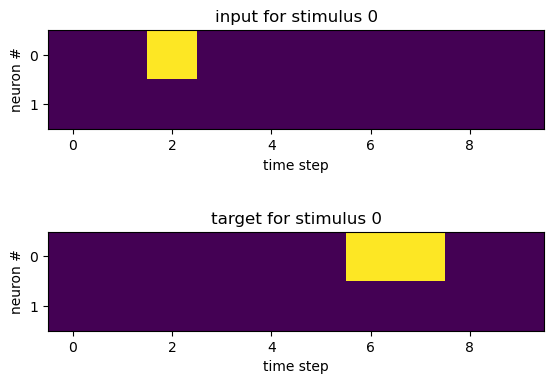

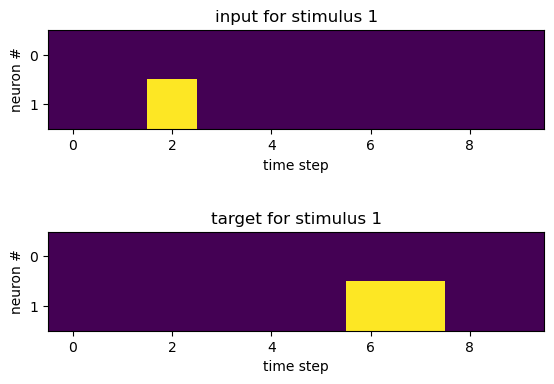

In [3]:
# graphically represent trial

t0 = Trial(stimulus=0)
t1 = Trial(stimulus=1)           
fig, axs = plt.subplots(2, 1, sharey=True)
axs[0].imshow(t0.stimulus.transpose(0,1))
axs[0].set(xlabel="time step", ylabel="neuron #")
axs[0].set_title("input for stimulus 0")


axs[1].imshow(t0.target.transpose(0,1))
axs[1].set(xlabel="time step", ylabel="neuron #")
axs[1].set_title("target for stimulus 0")

fig, axs = plt.subplots(2, 1, sharey=True)
axs[0].imshow(t1.stimulus.transpose(0,1))  
axs[0].set(xlabel="time step", ylabel="neuron #")
axs[0].set_title("input for stimulus 1")

axs[1].imshow(t1.target.transpose(0,1)) 
axs[1].set(xlabel="time step", ylabel="neuron #")
axs[1].set_title("target for stimulus 1")


In [5]:
net = CTRNN.CTRNN(2, 50, 2)
naiive_net = copy.deepcopy(net)

criterion = nn.MSELoss()
learningrate = 0.0001
optimizer = optim.Adam(net.parameters(), lr=learningrate)
optimizer.zero_grad()

losstrack = []

# get output for each stim for naiive network

out_og_t0, _ = naiive_net(t0.stimulus)
out_og_t1, _ = naiive_net(t1.stimulus)

# create and train on a whole bunch of trials
loss = 1
while loss >= 0.1:
    r = random.choice([0,1])
    t = Trial(stimulus=r)
    out, _ = net(t.stimulus)
    target = t.target
    loss = criterion(out, target)
    losstrack.append(loss.item())
    loss.backward()
    optimizer.step()

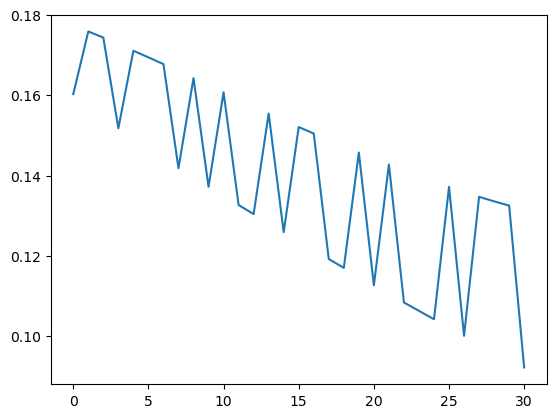

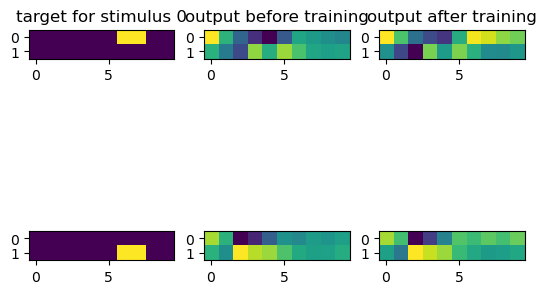

In [6]:
plt.plot(losstrack)

out_t0, _ = net(t0.stimulus)
out_t1, _ = net(t1.stimulus)

fig, axs = plt.subplots(2, 3)
axs[0,0].imshow(t0.target.transpose(0,1))    
axs[0,0].set(title="target for stimulus 0")

axs[0,1].imshow(out_og_t0.detach().numpy().transpose())   
axs[0,1].set(title="output before training")

axs[0,2].imshow(out_t0.detach().numpy().transpose())  
axs[0,2].set(title="output after training")

axs[1,0].imshow(t1.target.transpose(0,1))
axs[1,1].imshow(out_og_t1.detach().numpy().transpose())
axs[1,2].imshow(out_t1.detach().numpy().transpose())


Text(0.5, 1.0, 'Hidden activity for stimulus 1')

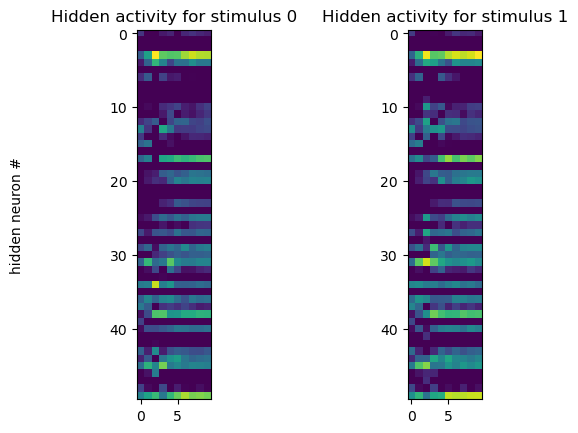

In [7]:
# visualize hidden activity

out_t0, h0 = net(t0.stimulus)
out_t1, h1 = net(t1.stimulus)


fig, axs = plt.subplots(1, 2)
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("hidden neuron #")

axs[0].imshow(h0.detach().numpy().transpose())
axs[0].set_title('Hidden activity for stimulus 0')
axs[1].imshow(h1.detach().numpy().transpose())
axs[1].set_title('Hidden activity for stimulus 1')

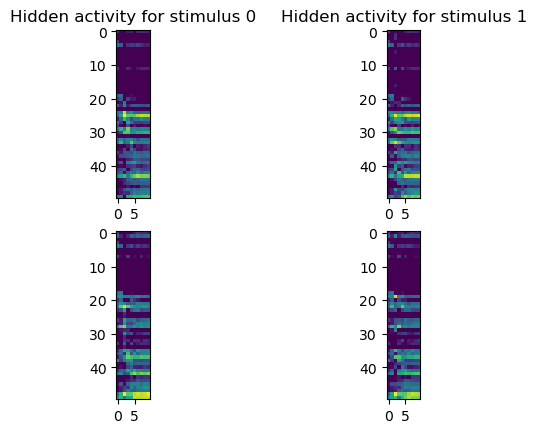

In [8]:
# sorted

hidden_h0 = h0.detach().numpy().transpose()
max_h0 = hidden_h0.argmax(axis=1)
sorted_h0 = np.argsort(max_h0)
sort_h0 = hidden_h0[sorted_h0]

hidden_h1 = h1.detach().numpy().transpose()
max_h1 = hidden_h1.argmax(axis=1)
sorted_h1 = np.argsort(max_h1)
sort_h1 = hidden_h1[sorted_h1]

sort_h1byh0 = hidden_h1[sorted_h0]
sort_h0byh1 = hidden_h0[sorted_h1]

fig, axs = plt.subplots(2, 2)
axs[0,0].imshow(sort_h0)
axs[0,0].set_title('Hidden activity for stimulus 0')
axs[0,1].imshow(sort_h1byh0)
axs[0,1].set_title('Hidden activity for stimulus 1')

axs[1,0].imshow(sort_h1)
axs[1,1].imshow(sort_h0byh1)




In [9]:
# create list of trials so each simulation is getting the same data
ntrials = 10000
trials = [Trial(stimulus=random.randint(0,1)) for item in range(ntrials)]


In [11]:
trials_to_loss_dict = {}

for num_hidden in [50, 100]:
    print("hidden neurons: ", num_hidden)
    trials_to_loss = []

    for num_sims in range(3):
        print("simulation number: ", num_sims)
        net = CTRNN.CTRNN(2, num_hidden, 2)
        criterion = nn.MSELoss()
        learningrate = 0.0001
        optimizer = optim.Adam(net.parameters(), lr=learningrate)
        optimizer.zero_grad()

        for idx in range(ntrials):
            out, _ = net(trials[idx].stimulus)
            target = trials[idx].target
            loss = criterion(out, target)
            if loss < 0.01:
                trials_to_loss.append(idx)
                break

            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=2.0, norm_type=2)
            optimizer.step()
    
    trials_to_loss_dict[num_hidden] = trials_to_loss

print(trials_to_loss_dict)


hidden neurons:  50
simulation number:  0
simulation number:  1
simulation number:  2
hidden neurons:  100
simulation number:  0
simulation number:  1
simulation number:  2
{50: [321, 434, 328], 100: [249, 209, 242]}
